In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sound-classification-of-animal-voice/Animal_Sound.csv
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_46.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_42.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_32.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_34.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_29.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_23.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_45.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_6.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_41.wav
/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_19.wav
/kaggle/input/sound-classification-of-anima

# Input Library

In [2]:
import librosa
import librosa.display

import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

print("library set!")

2026-01-03 20:26:07.457384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767471967.717081      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767471967.787305      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767471968.373615      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767471968.373660      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767471968.373663      17 computation_placer.cc:177] computation placer alr

library set!


# Input Data

In [3]:
# Create csv for the path of each animal sound
CURRENT_DIR = os.getcwd()
DATASET_DIR = "/kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros"

# Create list for the each animal's name (now, i use only 8 type of voices)
animalList = ['Lion', 'Bear', 'Cat', 'Dog', 'Chicken', 'Sheep', 'Frog', 'Dolphin']

data = []

for animal in animalList:
    if animal == "Lion":
        folder_path = os.path.join(DATASET_DIR, "Aslan")
    else:
        folder_path = os.path.join(DATASET_DIR, animal)

    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        
        for file_name in files:
            if file_name.endswith('.wav'):
                full_path = os.path.join(folder_path, file_name)
                data.append([full_path, animal])

# Create DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

df.head()

,file_path,label
0,/kaggle/input/sound-classification-of-animal-v...,Lion
1,/kaggle/input/sound-classification-of-animal-v...,Lion
2,/kaggle/input/sound-classification-of-animal-v...,Lion
3,/kaggle/input/sound-classification-of-animal-v...,Lion
4,/kaggle/input/sound-classification-of-animal-v...,Lion


# **Mel-Spectogram (Example Usage)**

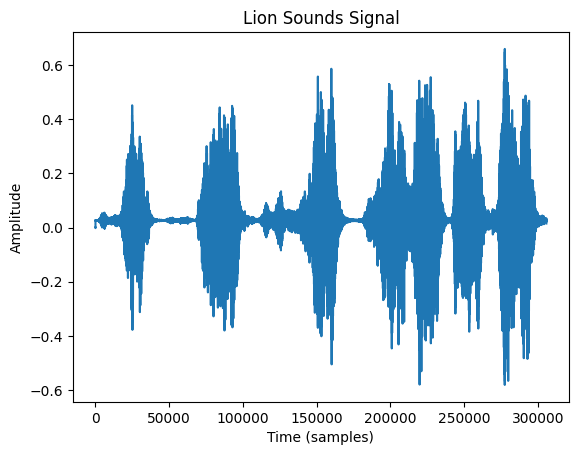

In [4]:
# Signal plotting
y, sr = librosa.load(df['file_path'][0])

plt.plot(y);
plt.title(df['label'][0] + " Sounds Signal");
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

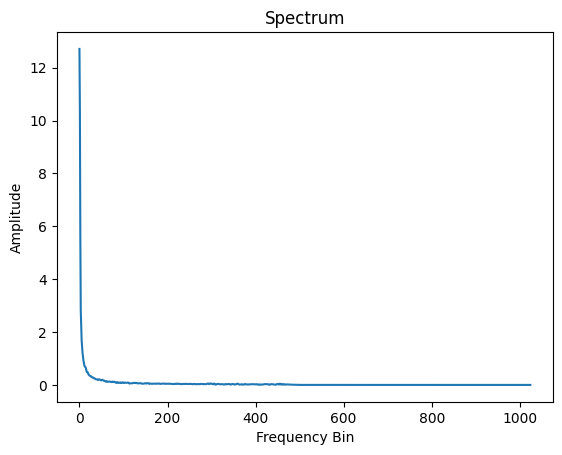

In [5]:
# Fourier Transform
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))

plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

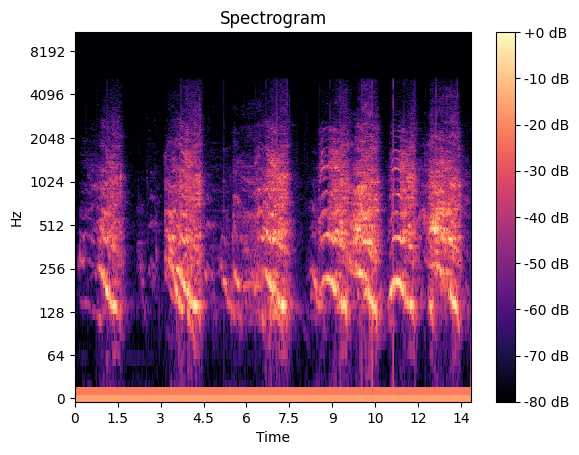

In [6]:
# Normal Spectogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)

librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

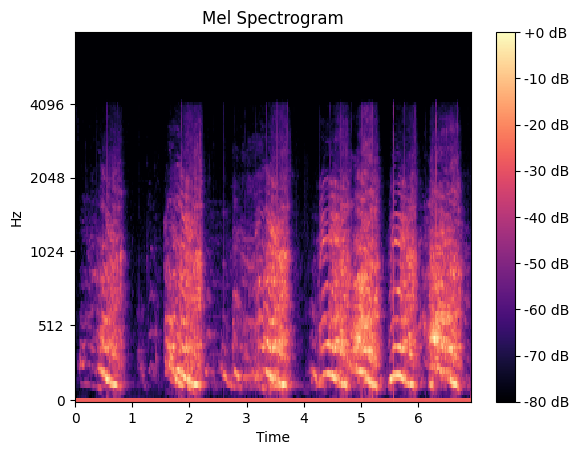

In [7]:
# Mel Spectogram
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

# Pre-processing

In [8]:
# Make directory to save mel-spectogram image dataset
melDataset = "/kaggle/working/Mel-Spectogram"

if os.path.exists(melDataset):
    print("Folder exist! Skip current process.")
else:
    os.mkdir(melDataset)
    print(f"Directory '{melDataset}' created.")

for animal in animalList:
    fullMelDataset = os.path.join(melDataset, animal)

    if os.path.exists(fullMelDataset):
        print("Folder exist! Skip current process.")
    else:
        os.mkdir(fullMelDataset)
        print(f"Directory '{fullMelDataset}' created.")

Directory '/kaggle/working/Mel-Spectogram' created.
Directory '/kaggle/working/Mel-Spectogram/Lion' created.
Directory '/kaggle/working/Mel-Spectogram/Bear' created.
Directory '/kaggle/working/Mel-Spectogram/Cat' created.
Directory '/kaggle/working/Mel-Spectogram/Dog' created.
Directory '/kaggle/working/Mel-Spectogram/Chicken' created.
Directory '/kaggle/working/Mel-Spectogram/Sheep' created.
Directory '/kaggle/working/Mel-Spectogram/Frog' created.
Directory '/kaggle/working/Mel-Spectogram/Dolphin' created.


In [9]:
# Save mel-spectogram image to the new folder
output_dir = melDataset

print("Generating Mel-Spectrogram...")
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        file_path = row['file_path']
        label = row['label']
        
        # Mapping for special label
        target_folder_name = folder_map.get(label, label)
        
        save_dir = os.path.join(output_dir, target_folder_name)
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)

        # Save path format from .wav to .png
        base_filename = os.path.basename(file_path).replace('.wav', '.png')
        save_path = os.path.join(save_dir, base_filename)

        # Load audio
        y, sr = librosa.load(file_path)
        
        # Generate Mel Spectrogram
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

        plt.figure(figsize=(10, 4))
        plt.axis('off') 
        
        librosa.display.specshow(mel_spect_db, sr=sr, hop_length=1024, x_axis='time', y_axis='mel', fmax=8000)

        # Save image
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()

    except Exception as e:
        print(f"Error from {file_path}: {e}")
        continue

print(f"Finish! Image has been saved in folder {output_dir}")

Generating Mel-Spectrogram...


100%|██████████| 400/400 [00:00<00:00, 13203.54it/s]

Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_46.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_42.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_32.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_34.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_29.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_23.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/Animal-Soundprepros/Aslan/Lion_45.wav: name 'folder_map' is not defined
Error from /kaggle/input/sound-classification-of-animal-voice/

# **Modelling**

In [10]:
# Image Configuration
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Load Training Data (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
  melDataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Load Validation Data (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
  melDataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Check class name
class_names = train_ds.class_names
print("Kelas yang ditemukan:", class_names)

# Performance Optimation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 0 files belonging to 8 classes.
Using 0 files for training.


ValueError: No images found in directory /kaggle/working/Mel-Spectogram. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [ ]:
# Create CNN Model
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
  # Zoom dikit biar dia belajar fokus ke fitur, bukan posisi pixel
  layers.RandomZoom(0.1), 
  # Contrast biar dia gak terpaku sama tebal tipis warna
  layers.RandomContrast(0.1),
])

model = models.Sequential([
  # Input Layer & Rescaling (Normalisasi pixel 0-255 jadi 0-1)
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

  # Augmentation
  data_augmentation,
  
  # Convolutional Block 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Convolutional Block 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
    
  # Convolutional Block 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Flattening (Change 2D array to 1D vector)
  layers.Flatten(),
  
  # Dense Layer (Fully Connected)
  layers.Dense(128, activation='relu'),
  
  # Dropout (Drop 50% neuron randomly for Overfitting mitigation)
  layers.Dropout(0.6),
  
  # Output Layer (Softmax for Multi-Class Classification)
  layers.Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Lihat ringkasan model
model.summary()

In [ ]:
# Callback Class
class HentikanTraining(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.85): 
            print("\n\nAccuracy has ben surpassed 92%! Training is stopped...")
            self.model.stop_training = True

# Callback Innitialization
my_callback = HentikanTraining()

print("Callback Set!")

# **Training and Visualization**

In [ ]:
# Training Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[my_callback]
)

In [ ]:
# Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True) # Tambahin grid biar gampang baca angkanya

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

print("Melakukan prediksi pada data validasi...")

# Loop each batch
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names) # class_names diambil dari step awal tadi

plt.xlabel('Predicted Label (Tebakan Model)')
plt.ylabel('True Label (Kunci Jawaban)')
plt.title('Confusion Matrix: Hasil Klasifikasi Suara Hewan')
plt.show()

# CLASSIFICATION REPORT (DETAIL)
print("\n=== Detail Performa per Kelas ===\n")
print(classification_report(y_true, y_pred, target_names=class_names))